In [1]:
import keras
from keras.optimizers import Adam, SGD
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import random
import cv2
import os
import pickle

Using TensorFlow backend.


In [2]:
#Checking if pickled data of images exists
print("Checking if pickled data of images exists")
data = []
label = []
if os.path.exists('pickled_data/melanoma.pkl'):
    print("Pickled data of images exist")
    dataset = pickle.load(open( 'pickled_data/melanoma.pkl', 'rb'))
    data = dataset['data']
    label = dataset['label']
else:
    print("Pickled data doesn't exist, loading data")
    if not os.path.exists('pickled_data'):
        os.makedirs('pickled_data')
    directory = os.fsencode("melanoma")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        path = str('melanoma/' + filename)
        image = cv2.imread(path)
        image = cv2.resize(image, (64, 64))
        image = img_to_array(image)
        data.append(image)
        label.append(1)

    directory = os.fsencode("others")
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        path = str('others/' + filename)
        image = cv2.imread(path)
        image = cv2.resize(image, (64, 64))
        image = img_to_array(image)
        data.append(image)
        label.append(0)
    dataset = {}
    dataset['data'] = data
    dataset['label'] = label
    pickle.dump(dataset, open('pickled_data/melanoma.pkl', 'wb'))
print("Data is loaded")

Checking if pickled data of images exists
Pickled data of images exist
Data is loaded


In [3]:
#Converting data and label in NP arrays and Normalising data 
data = np.array(data, dtype="float") / 255.0
label = np.array(label)

#Splitting into train and test dataset
num_classes=2
(x_train, x_test, y_train, y_test) = train_test_split(data,label, test_size=0.20, random_state=2018)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [4]:
class_weight=[0.4,2.7]

In [5]:
from sklearn.metrics import fbeta_score

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    print("y_true"+str(y_true))
    print("y_pred"+str(y_pred))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

from scipy import stats

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return (2*precision(y_true, y_pred)*recall(y_true, y_pred))/(precision(y_true, y_pred)+recall(y_true, y_pred))

In [6]:
batch_size = 128
epochs = 10

#64*64 resolution, 3 stands for RGB
input_shape = (64, 64,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',input_shape=input_shape,strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#Compiling model: Using categorical crossentropy loss function and adagrad optimiser
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics = ['accuracy',recall,precision,fmeasure])

#Training model
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),class_weight=class_weight)

#Validating model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test recall:', score[2])
print('Test precision:', score[3])
print('Test fmeasure:', score[4])

y_trueTensor("dense_2_target:0", shape=(?, ?), dtype=float32)
y_predTensor("dense_2/Softmax:0", shape=(?, 2), dtype=float32)
y_trueTensor("dense_2_target:0", shape=(?, ?), dtype=float32)
y_predTensor("dense_2/Softmax:0", shape=(?, 2), dtype=float32)
y_trueTensor("dense_2_target:0", shape=(?, ?), dtype=float32)
y_predTensor("dense_2/Softmax:0", shape=(?, 2), dtype=float32)
Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 6s - loss: 0.5072 - acc: 0.7656 - recall: 0.7656 - precision: 0.7656 - fmeasure: 0.7656 - val_loss: 0.4886 - val_acc: 0.8275 - val_recall: 0.8275 - val_precision: 0.8275 - val_fmeasure: 0.8275
Epoch 2/10
1600/1600 [==============================] - 5s - loss: 0.4908 - acc: 0.8094 - recall: 0.8094 - precision: 0.8094 - fmeasure: 0.8094 - val_loss: 0.4573 - val_acc: 0.8275 - val_recall: 0.8275 - val_precision: 0.8275 - val_fmeasure: 0.8275
Epoch 3/10
1600/1600 [==============================] - 5s - loss: 0.4863 - acc:

In [7]:
y_pred=model.predict(x_test)


In [8]:
from sklearn.metrics import confusion_matrix
cnf_matrix= confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


In [9]:
cnf_matrix

array([[331,   0],
       [ 69,   0]])

In [10]:
import itertools
def plot_confusion_matrix(cm, classes,name = "Cf.png",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(name)
    plt.show()

[[331   0]
 [ 69   0]]


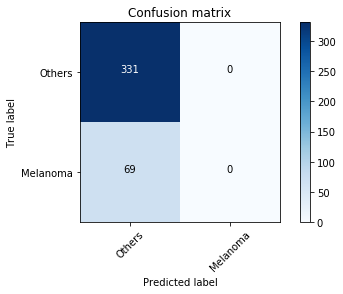

In [11]:

class_names = ['Others', 'Melanoma']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      name = "Confusion_matrix.png",
                      title='Confusion matrix')